In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import cross_val_score
from recourse.builder import RecourseBuilder
from recourse.builder import ActionSet
from lime.lime_tabular import LimeTabularExplainer

from scipy.stats import wasserstein_distance


In [2]:
np.random.seed(0)
random.seed(0)

In [3]:
def gen_data(means, covs, clf, points=2500):
    data = np.random.multivariate_normal(means, covs, points)
    data = pd.DataFrame(data, columns=['X0', 'X1'])
    data['target'] = clf(data['X0'], data['X1'])
    data['target'] = data['target'].astype(float)
    return data

In [4]:
def get_recourse(row, clf, learning_rate=0.002, max_iter=100000):
    rec = np.array(row).reshape(1,-1).astype(float)
    iter_count = 0
    while(clf.predict(rec) == [0]):
        rec += learning_rate * clf.coef_
        if iter_count >= max_iter:
            return None
        iter_count += 1
    return rec

def gen_recourses(data, clf):
    need_rec = data[data['target'] == 0]
    need_rec = need_rec[['X0', 'X1']]
    recourses = []
#     for index, row in tqdm(need_rec.iterrows(), total=need_rec.shape[0]):
    for index, row in need_rec.iterrows():
        recourses.append(get_recourse(row, clf)[0])
    return pd.DataFrame(np.array(recourses), columns=['X0','X1']), None

In [5]:
means = [0,0]
covs = [[1,0],[0,1]]
def clf(X0, X1):
    return X0 + X1 > 0
def get_means(alpha):
    return [alpha, alpha]

In [6]:
def run_single(means1, covs1, means2, covs2, clf1, clf2):
    D1 = gen_data(means1, covs1, clf1)
    D2 = gen_data(means2, covs1, clf2)

    M1 = LogisticRegression(random_state=0, solver='liblinear')
    M1.fit(D1[['X0', 'X1']], D1['target'])

    CF1, ncf1 = gen_recourses(D1, M1)

    M2 = LogisticRegression(random_state=0, solver='liblinear')
    M2.fit(D2[['X0', 'X1']], D2['target'])

    CF1['target'] = clf(CF1['X0'], CF1['X1'])
    CF1['target'] = CF1['target'].astype(float)
    CF1['M1_pred'] = M1.predict(CF1[['X0', 'X1']])
    CF1['M2_pred'] = M2.predict(CF1[['X0', 'X1']])

    invpct = 100*(1-np.mean(CF1['M2_pred']))
    # print('Invalidation is', invpct, '%')
    M1_acc = cross_val_score(M1, D1[['X0', 'X1']], D1['target'], cv=10).mean()
    # print('M1 cross val acc', M1_acc)
    M2_acc = cross_val_score(M2, D2[['X0', 'X1']], D2['target'], cv=10).mean()
    # print('M2 cross val acc', M2_acc)
    return invpct, M1_acc, M2_acc, wasserstein_distance(D1['X0'], D2['X0'])

In [7]:
def runall(alphas):
    inv, M1accs, M2accs, shifts = [], [], [], []
    for alpha in tqdm(alphas):
        invpct, m1, m2, shift = run_single(means, covs, get_means(alpha), covs, clf, clf)
        inv.append(invpct)
        M1accs.append(m1)
        M2accs.append(m2)
        shifts.append(shift)
    return inv, M1accs, M2accs, shifts

In [8]:
def gen_data(means, covs, clf, points=20000):
    data = np.random.multivariate_normal(means, covs, points)
    data = pd.DataFrame(data, columns=['X0', 'X1'])
    data['target'] = clf(data['X0'], data['X1'])
    data['target'] = data['target'].astype(float)
    return data

In [9]:
alphas3 = [i/100 for i in range(60,85,10)]
alphas3 += [i/100 for i in range(85,95,2)]
alphas3 += [i/100 for i in range(95,98,1)]
alphas3 += [i/1000 for i in range(980,1021,5)]
alphas3 += [i/100 for i in range(103,105,1)]
alphas3 += [i/100 for i in range(105,116,2)]
alphas3 += [i/100 for i in range(120,151,10)]

# 100*(np.array(alphas3)-1)
# alphas3 = alphas3[12:19]
alphas3 = [i/10000 for i in range(-11000,11001,1375)]
alphas3

[-1.1,
 -0.9625,
 -0.825,
 -0.6875,
 -0.55,
 -0.4125,
 -0.275,
 -0.1375,
 0.0,
 0.1375,
 0.275,
 0.4125,
 0.55,
 0.6875,
 0.825,
 0.9625,
 1.1]

In [10]:
inv3, M1accs3, M2accs3, shifts = runall(alphas3)

<Figure size 1080x720 with 0 Axes>

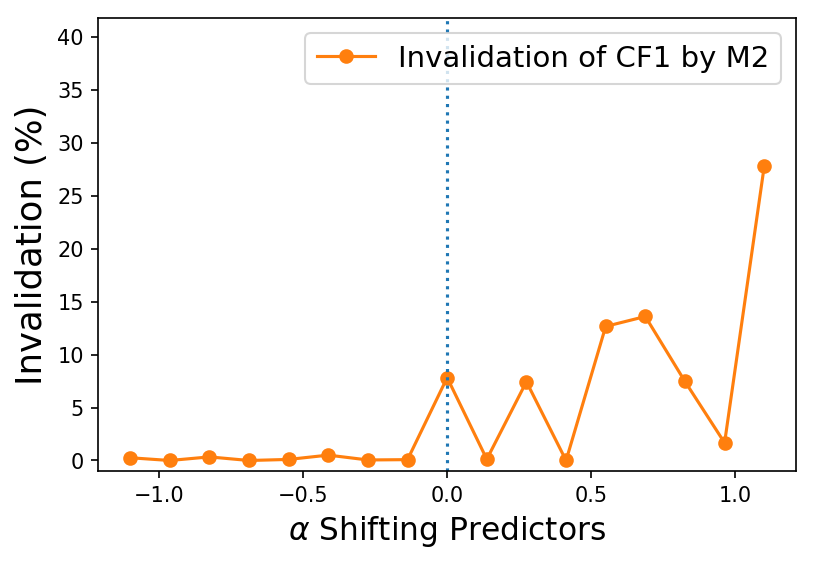

In [21]:
t = -np.array(alphas3)
data1 = inv3
# data2 = 100*np.array(M1accs3)+np.random.random(len(alphas3))
# data3 = 100*np.array(M2accs3)+np.random.random(len(alphas3))
data2 = 100*np.array(M1accs3)
data3 = 100*np.array(M2accs3)

plt.figure(dpi=180)
fig, ax1 = plt.subplots()
fig.set_dpi(150)

color = 'C1'
ax1.set_xlabel(r'$\alpha$ Shifting Predictors', fontsize=15)
ax1.set_ylabel('Invalidation (%)', fontsize=17)#, color='C1')
ax1.plot(t, data1, color=color, label='Invalidation of CF1 by M2', marker='o')
ax1.tick_params(axis='y')#, labelcolor='C1')
ax1.set_ylim(-1, 14+max(data1))
# ax1.set_xlim(-105, 105)
ax1.axvline(0, linestyle=':')
# ax1.axvline(0, color='C3', linestyle=':', label='No Shift')
# ax1.legend(loc=2)
ax1.legend(fontsize=14)
# ax1.set_xscale('symlog')

# ax2 = ax1.twinx()
# color = 'C0'
# ax2.set_ylabel('10-Fold CrossVal Accuracy (%)', color='C0')
# ax2.plot(t-0.01, data2, label='M1 acc.', color='C0', marker='1', zorder=2, alpha=0.5)
# ax2.plot(t+0.01, data3, label='M2 acc.', color='C2', marker='2', zorder=1, alpha=0.5)
# # ax2.scatter(t-0.01, data3, label='M2 acc.', color='red', marker='.')
# ax2.tick_params(axis='y', labelcolor='C2')
# ax2.set_ylim(-1, 101)
# ax2.legend(loc=1)

# plt.title('Invalidation vs Distribution Shifts')
plt.show()


In [12]:
print(t)
print(data1)
print(data2)
print(data3)

[ 1.1     0.9625  0.825   0.6875  0.55    0.4125  0.275   0.1375 -0.
 -0.1375 -0.275  -0.4125 -0.55   -0.6875 -0.825  -0.9625 -1.1   ]
[27.766739519173456, 1.6705714576754627, 7.462686567164178, 13.594863048058592, 12.65670444288437, 0.0, 7.436614094629668, 0.11982026959560521, 7.823570501945909, 0.07973686833450122, 0.04990518015770551, 0.5077152812344443, 0.09996001599360538, 0.0, 0.3385779725154303, 0.0, 0.2587837165322959]
[99.93000748 99.945      99.93999749 99.85999498 99.87999499 99.92498999
 99.9399925  99.86999997 99.875005   99.96000249 99.9500025  99.88002497
 99.90499498 99.90999499 99.93000749 99.97       99.95998999]
[99.78001248 99.96       99.925      99.91499998 99.88       99.960005
 99.90998498 99.935      99.895      99.9400025  99.88499748 99.93500749
 99.80999248 99.92000498 99.894995   99.84999497 99.90001498]
